# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Описание данных** 

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Открываем и изучаем файл

In [1]:
# импорт библиотек
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt
import numpy as np

#импортируем tqdm
from tqdm import tqdm

In [2]:
#откроем файл
df = pd.read_csv('/datasets/users_behavior.csv')
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
#общая информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
#проверим данные на пропуски
df.isnull().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [5]:
#проверим данные на дубликаты
df.duplicated().sum()

0

In [6]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [7]:
#посмотрим на сбалансированность столбца is_ultra (наш target)
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

_Действительно, наши данные несбалансированы в сторону 0 примерно в 2.3 раза._

In [8]:
#посмотрим корреляцию признаков
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


## Разобьём данные на выборки

Выборки:
1. тренировочная: features_train, target_train
2. валидационная: features_valid, target_train
3. тестовая: features_test, target_train

In [9]:
#разобьём данные на 2 выборки: тренировочную (60%) и тестово-валидационную (40%)
train, test_valid = train_test_split(df, test_size=0.4, random_state=12345, stratify=df['is_ultra'])

In [10]:
features_train = train.drop('is_ultra', axis=1)
target_train = train['is_ultra']

In [11]:
features_test_valid = test_valid.drop('is_ultra', axis=1)
target_test_valid = test_valid['is_ultra']

In [12]:
#теперь разобьём на валидационную (20%) и тестовую (20%) выборки 
features_valid, features_test, target_valid, target_test = train_test_split(
                features_test_valid, target_test_valid, test_size=0.5,
                random_state=12345, stratify=target_test_valid)

## Исследование модели

**Tree Classifier**

Рассмотрим влияние параметров criterion, max_depth, max_features и splitter на качество модели. **Criterion** - гиперпараметр, который используется для определения качества разбиения на части. **Max_depth** - максимальная глубина дерева. **Max_features** - максимальное количество признаков, учитывающиеся при разбиении. **Splitter** - гиперпараметр, который определяет стратегию, используемую для выбора разбиения в каждом узле.

In [17]:
best_depth = 0
best_accuracy = 0
best_feature = ''
best_splitter = 0
best_criterion = ''

splitter_value = ['best', 'random']
maxfeatures_value = ['auto', 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8, 1]


for depth in range(1, 51):
    for feature in maxfeatures_value:
        for split in splitter_value:
            model_tree_classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth=depth, 
                                               min_samples_leaf=1, min_samples_split=5,
                                               max_features=feature, splitter=split)
            model_tree_classifier.fit(features_train, target_train)
            accuracy_train = model_tree_classifier.score(features_train, target_train)
            
            predictions_valid = model_tree_classifier.predict(features_valid)
            accuracy_valid = model_tree_classifier.score(features_valid, target_valid)
    
            if accuracy_valid > best_accuracy:
                best_model_tree = model_tree_classifier
                best_accuracy = accuracy_valid
                best_depth = depth
                best_feature = feature
                best_splitter = split
        
print('Качество наилучшей модели: {}.\nЗначение глубины: {}.\nЗначение параметра max_features: {}. \nЗначение параеметра splitter: {}. '
      .format(best_accuracy, best_depth, best_feature, best_splitter))

Качество наилучшей модели: 0.8087091757387247.
Значение глубины: 7.
Значение параметра max_features: auto. 
Значение параеметра splitter: best. 


In [14]:
acc_train = []
acc_valid = []

for depth in range(1, 51):
    model_tree_classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth=depth, 
                                               min_samples_leaf=1, min_samples_split=5,
                                               max_features=0.6, splitter='random')
    model_tree_classifier.fit(features_train, target_train)
    accuracy_train = model_tree_classifier.score(features_train, target_train)
    acc_train.append(accuracy_train)
    predictions_valid = model_tree_classifier.predict(features_valid)
    accuracy_valid = model_tree_classifier.score(features_valid, target_valid)
    acc_valid.append(accuracy_valid)

Качество наилучшей модели: 0.81, также было посчитано значение метрики rmse на валидационной выборке. А наилучшие значения параметров - это максимальная глубина = 11, max_features - 'auto, стратегия для разбиения в каждом узле - random.

_Убрала перебор по criterion, поставила значение как у лучшей модели._

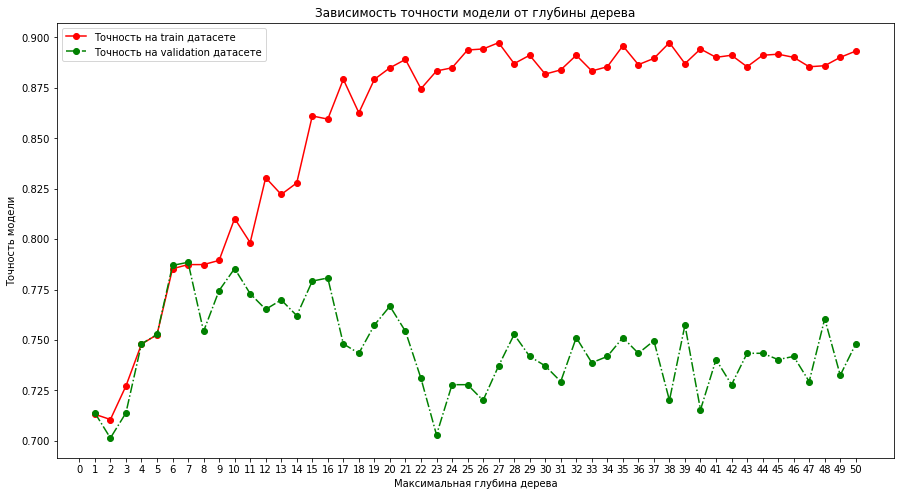

In [15]:
plt.figure(figsize=(15, 8))
plt.title('Зависимость точности модели от глубины дерева')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Точность модели')
plt.xticks(np.arange(0, 51, 1))

x = list(range(1, 51, 1))
plt.plot(x, acc_train, 'o-r', label='Точность на train датасете')
plt.plot(x, acc_valid, 'o-.g', label='Точность на validation датасете')
plt.legend();

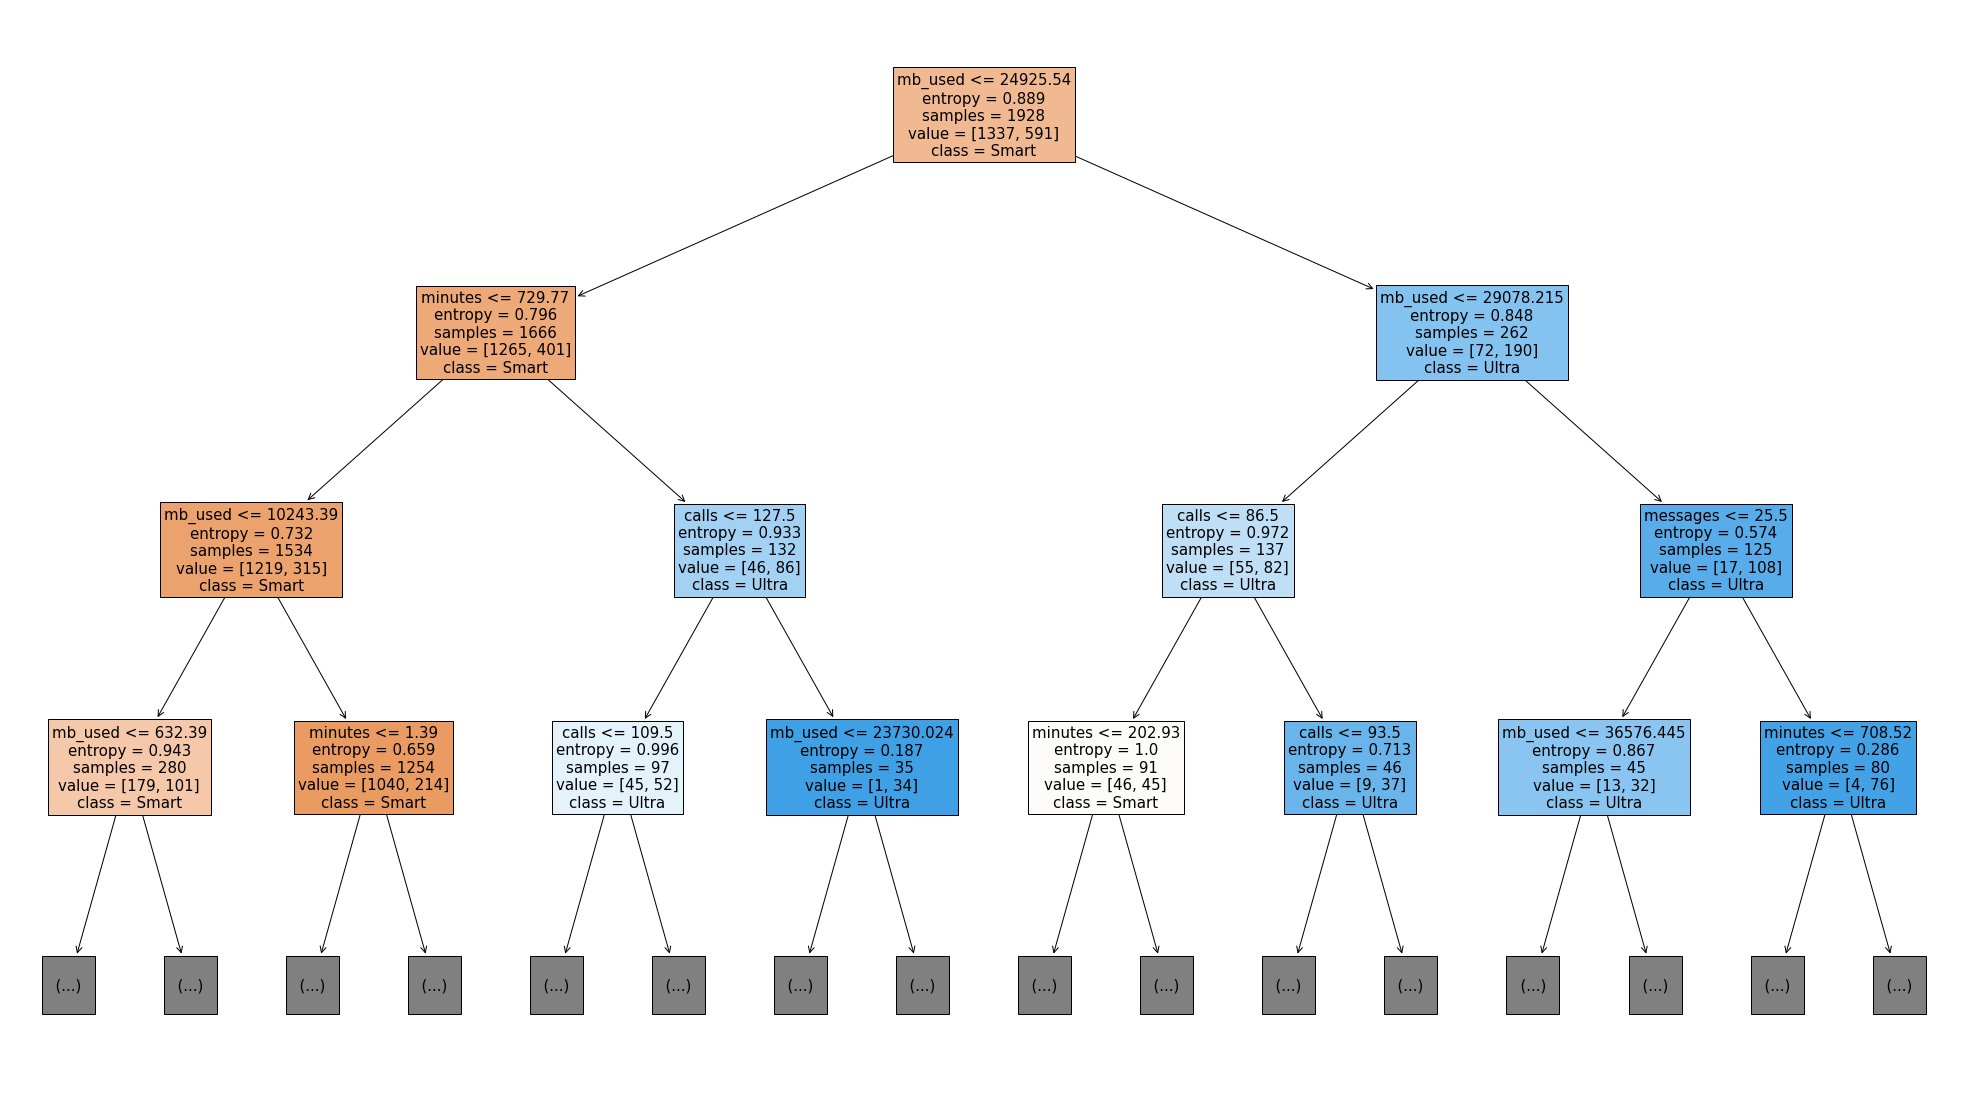

In [20]:
#построим дерево
from sklearn import tree

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(best_model_tree, 
               feature_names=features_train.columns.values, 
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 15,
               max_depth = 3     # Это чтобы прорисовывало 3 уровня, не глубже
                  )

**Random Forest**

Рассмотрим влияние параметров criterion, n_estimators, max_depth, max_features и bootstrap на качество модели. 
**Criterion** - гиперпараметр, который используется для определения качества разбиения на части. 
**N_estimators** - количество деревьев, использовавшихся в обучении модели.
**Max_depth** - максимальная глубина дерева. 
**Max_features** - максимальное количество признаков, учитывающиеся при разбиении. 
**Bootstrap** - гиперпараметр, который определяет, производится ли случайная выборка из данных для построения деревьев. 

In [21]:
best_depth = 0
best_accuracy = 0
best_feature = ''
best_splitter = 0
best_criterion = ''
best_strap = ''
best_est = 0

criterion_value = ['gini', 'entropy']
maxfeatures_value = ['auto', 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8, 1]


for n_est in tqdm(range(5, 26, 5)):
    for depth in range(1, 21):
        for boot in [True, False]:
            for cri in criterion_value:
                for feature in maxfeatures_value:
                    model_random_forest = RandomForestClassifier(
                    n_estimators=n_est, criterion=cri, max_depth=depth,
                    min_samples_split=5, min_samples_leaf=1, max_features=feature,
                    bootstrap=boot)
                    
                    model_random_forest.fit(features_train, target_train)
                    accuracy = model_random_forest.score(features_valid, target_valid)
                    
                    if accuracy > best_accuracy:
                        best_model_random = model_random_forest
                        best_accuracy = accuracy
                        best_n_est = n_est
                        best_depth = depth
                        best_feature = feature
                        best_criterion = cri
                        best_bootstrap = boot
                        
print('Качество наилучшей модели: {}.\nКоличество деревьев:{}.\nЗначение глубины: {}.\nЗначение параметра criterion_value: {}. \nЗначение параметра max_features: {}. \nЗначение параметра bootstrap: {}. '
      .format(best_accuracy, best_n_est, best_depth, best_criterion, best_feature, best_bootstrap))                        

100%|██████████| 5/5 [03:14<00:00, 38.91s/it]

Качество наилучшей модели: 0.8289269051321928.
Количество деревьев:20.
Значение глубины: 9.
Значение параметра criterion_value: entropy. 
Значение параметра max_features: 0.2. 
Значение параметра bootstrap: True. 


Качество наилучшей модели: 0.83. Оптимальное количество деревьев - это 20. А наилучшие значения параметров - это максимальная глубина = 9, criterion_value: entropy. Значение параметра max_features = 0.2. Также нужно отметить, что при построении деревьев случайная выборка производилась.

_Добавила tqdm_

**Logistic Regression**

На качество модели в основном меняют 2 параметра C и penalty, осуществим перебор по ним.

* penalty указывает на норму 'l1' или 'l2'
* C - обратная сила регуляризации, положительное число

In [23]:
best_penalty = ' '
best_accuracy = 0

penalty_values = ['l1', 'l2']
for pen in penalty_values:
    for c_const in range(1, 21):
        model_log_reg = LogisticRegression(penalty=pen, C=c_const, solver='liblinear', multi_class = 'ovr')
        model_log_reg.fit(features_train, target_train)
        predictions_valid = model_log_reg.predict(features_valid)
        
        accuracy = model_log_reg.score(features_valid, target_valid)
        
        if accuracy > best_accuracy:
            best_model_regression = model_log_reg
            best_accuracy = accuracy
            best_penalty = pen
            best_c = c_const

print('Качество наилучшей модели: {}.\nЗначение penalty: {}. \nЗначение С: {}.'
      .format(best_accuracy, best_penalty, best_c))

Качество наилучшей модели: 0.7402799377916018.
Значение penalty: l1. 
Значение С: 3.


Качество наилучшей модели: 0.74, также было посчитано значение метрики rmse на валидационной выборке. А наилучшие значения параметров - это С = 3, а норма, по которой начисляется штраф, - это норма 'l1'. 

## Проверка модели на тестовой выборке

**Random Forest**

In [24]:
#проверим качество модели model_random_forest
accuracy_mrf = best_model_random.score(features_test, target_test)
print('Квчество модели model_tree_classifier равно {}'.format(accuracy_mrf))

Квчество модели model_tree_classifier равно 0.8242612752721618


Наилучшее качество достигается при использовании Random forest и равно 0.82. 

Гиперпараметры модели с наилучшим качеством таковы:
* Количество деревьев: 20.
* Значение глубины: 13.
* Значение параметра criterion_value: gini. 
* Значение параметра max_features: 0.2. 
* Значение параеметра bootstrap: True. 

## Проверка модели на адекватность

В качестве простейшей модели возьмём Dummy Classifier c стратегией most_frequent, то есть наиболее часто встречающуюся метку в наборе. В нашем случае это будет 0.

In [52]:
model_dummy = DummyClassifier(strategy='most_frequent')
model_dummy.fit(features_train, target_train)
accuracy_dummy = model_dummy.score(features_test, target_test)
if accuracy_dummy > accuracy_mrf:
    print('Наша модель неадекватна.\nКачество наивного прогноза: {}\nКачество лучшей модели: {}.'
         .format(accuracy_dummy, accuracy_mrf))
else:
    print('Наша модель адекватна.\nКачество наивного прогноза: {}\nКачество лучшей модели: {}.'
         .format(accuracy_dummy, accuracy_mrf))

Наша модель адекватна.
Качество наивного прогноза: 0.6936236391912908
Качество лучшей модели: 0.8242612752721618.


## Вывод

В ходе наших исследований был проведён анализ трёх моделей: дерево решений, случайный лес и логистическая регрессия. Наилучшее качество на обучающем наборе данных достигается при использовании модели случайный лес (0.81). На тесте качество модели несколько снизилось (0.78), но по-прежнему это лучший результат среди всех моделей. 

Наилучшие гиперпараметры, которые использовались при обучении модели random forest представлены ниже:
* Количество деревьев: 10.
* Значение глубины: 8.
* Значение параметра criterion_value: entropy. 
* Значение параметра max_features: 0.4. 
* Значение параеметра bootstrap: True. 